# Modelling decision making under uncertainty

Here we show how the Markov decision process (MDP) framework can be extended to allow uncertainty about the states. This can be used to model a wide range of decision-making problems where there is uncertainty or noise associated with the state of the world.

We consider the example of the random dot motion discrimination task, where a subject must indicate the direction in which the majority of dots are moving. Here we model a two-stage formulation of this task, where the decision-maker can either make an immediate decision (i.e., at the first stage) on the basis of initial information, or choose to wait and gather further information before making their choice (i.e., at the second stage). The complete description of the problem can be found in the original paper: http://www.gatsby.ucl.ac.uk/~dayan/papers/NDM002wc.pdf


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats

## 1. Define the parameters of the model 

In [16]:
# INSERT CODE HERE
prior_x1 = 0.5
prior_x2 = 0.5
prior_x3 = 0.5
prior_x4 = 0.5

c_alphas = np.linspace(0, 10, 100)
c_betas = np.linspace(0, 10, 100)
sigma = 1


class Environment:
    def __init__(self):
        self.stages = ['alpha', 'beta']
        self.actions = {'alpha': ['L', 'R'], 'beta': ['L', 'R', 'C']}
        self.states = {'beta': ['x3', 'x4'], 'alpha': ['x1', 'x2']}
        self.means = {'beta': {'x3': 6, 'x4': 4}, 'alpha': {'x1': 6, 'x2': 4}}

    def get_states(self, stage):
        return self.states[stage]

## 2. Updating the belief state
The actual direction of motion ('state') is not completely observable to the subject. Hence, the subject can only rely on observations to compute the *belief* that the direction of motion is left or right (this is the posterior probability or 'belief state'). 

First we create a function to calculate the posterior probability of each state given the observation

In [17]:
def posterior(stage, observation):
    """ Function to calculate the posterior probability of each state given the observation
    Args:
        stage: the stage of the game
        observation: the observation
    Returns:
        posterior_1: the posterior probability of state 1
        posterior_2: the posterior probability of state 2

    """
    state_1 = env.get_states(stage)[0]
    state_2 = env.get_states(stage)[1]
    mean_1 = env.means[stage][state_1]
    mean_2 = env.means[stage][state_2]
    l_1 = stats.norm(mean_1, sigma).pdf(observation)
    l_2 = stats.norm(mean_2, sigma).pdf(observation)
    likelihood_ratio = l_1/l_2
    posterior_1 = 1/(1+likelihood_ratio*(prior_x2/prior_x1))
    posterior_2 = 1/(1+(likelihood_ratio)**(-1)*(prior_x2/prior_x1))
    return posterior_1, posterior_2

 Next, this function is used to update the belief on the first observation at step $\beta$ 

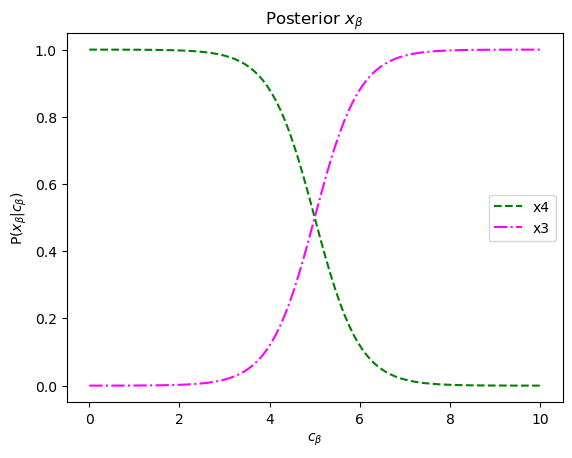

In [18]:
env = Environment()
c_alphas = np.linspace(0, 10, 100)
Posterior = np.zeros((2, len(c_alphas)))
stage = 'beta'
for i in range(len(c_alphas)):
    Posterior[0, i], Posterior[1, i] = posterior(stage, c_alphas[i])

plt.plot(c_alphas, Posterior[0, :], '--', c='green')
plt.plot(c_alphas, Posterior[1, :], '-.', c='magenta')
plt.legend(['x4', 'x3'])
plt.ylabel(r'P($x_{\beta}$|$c_{\beta}$)')
plt.xlabel(r'$c_{\beta}$')
plt.title(r'Posterior $x_{\beta}$')
plt.show()

The graph illustrates how the state (in our case x3 or x4, i.e. rightward or leftward motion) is deduced from the cue observation at the state 'Beta'. While extreme values of c_beta prompt the state almost exactly, c_beta values around 5 account for the most ambigous observations. 

Next we create a function to update the belief on observing another sample at step $\alpha$ 

In [19]:
def belief_alpha(observation_alpha, observation_beta):
    """ Function to calculate the belief of the alpha stage
    Args:
        observation_alpha: the observation of the alpha stage
        observation_beta: the observation of the beta stage
    Returns:
        belief: the belief of the alpha stage
    """

    stage = 'alpha'
    state_1 = env.get_states(stage)[0]
    state_2 = env.get_states(stage)[1]
    mean_1 = env.means[stage][state_1]
    mean_2 = env.means[stage][state_2]
    l_1 = stats.norm(mean_1, sigma).pdf(observation_alpha)
    l_2 = stats.norm(mean_2, sigma).pdf(observation_alpha)

    stage = 'beta'
    state_1 = env.get_states(stage)[0]
    state_2 = env.get_states(stage)[1]
    mean_1 = env.means[stage][state_1]
    mean_2 = env.means[stage][state_2]
    l_3 = stats.norm(mean_1, sigma).pdf(observation_beta)
    l_4 = stats.norm(mean_2, sigma).pdf(observation_beta)
    norm = (l_2*l_4*prior_x4 + l_1*l_3*prior_x3)
    belief = l_3*l_1*prior_x3/norm
    return belief

In [20]:
c_alphas = np.linspace(0, 10, 100)
c_betas = np.linspace(0, 10, 100)
Var = np.zeros((len(c_alphas), len(c_betas)))
for i in range(len(c_alphas)):
    for j in range(len(c_betas)):
        Var[i, j] = belief_alpha(c_alphas[i], c_betas[j])

Text(0.5, 1.0, 'Posterior P ($x_1$ | $c_{\\alpha}$, $c_{\\beta}$)')

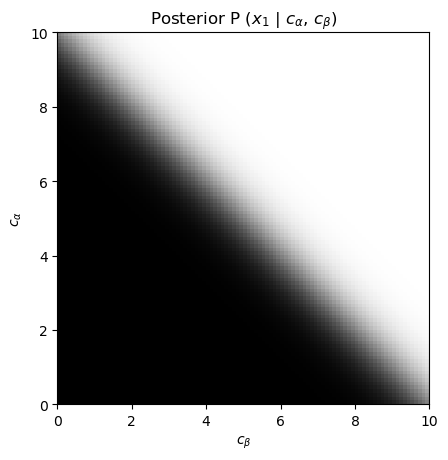

In [21]:
plt.matshow(Var, cmap='grey', origin='lower', extent=[0, 10, 0, 10])
plt.gca().xaxis.set_ticks_position('bottom')
plt.xlabel(r'$c_{\beta}$')
plt.ylabel(r'$c_{\alpha}$')
plt.title(r'Posterior P ($x_1$ | $c_{\alpha}$, $c_{\beta}$)')

The graph reflects the fact that calculating the probability of a state at 'Alpha' involves multiplying the likelyhoods of idependant individual observations at both 'Alpha' and 'Beta'. This is the core of Bayesian approach: each new observation/cue updates our believs. 

## 2. Solving for the optimal actions
Now that we have a way to update the belief states, we can use them to determine the best course of action at each of the steps (the 'optimal policy'). 



In POMDP's the current belief state is a sufficient statistic for the entire cue history (i.e. 'the future does not depend on the past, given the current state'); given the fact that the subject has already arrived at 'Alpha', it will be able to make a choice, based on c_alpha


We create a function that will calculate the value of the best action at $\alpha$ 

In [22]:
def action_value(observation_alpha, observation_beta):
    """ Function to calculate the action value
    Args:
        observation_alpha: the observation of the alpha stage
        observation_beta: the observation of the beta stage
    Returns:
        Value: the action value
    """

    stage = 'alpha'
    state_1 = env.get_states(stage)[0]
    state_2 = env.get_states(stage)[1]
    mean_1 = env.means[stage][state_1]
    mean_2 = env.means[stage][state_2]
    l_1 = stats.norm(mean_1, sigma).pdf(observation_alpha)
    l_2 = stats.norm(mean_2, sigma).pdf(observation_alpha)

    stage = 'beta'
    state_1 = env.get_states(stage)[0]
    state_2 = env.get_states(stage)[1]
    mean_1 = env.means[stage][state_1]
    mean_2 = env.means[stage][state_2]
    l_3 = stats.norm(mean_1, sigma).pdf(observation_beta)
    l_4 = stats.norm(mean_2, sigma).pdf(observation_beta)

    Value = max(l_3*l_1*prior_x3/(l_2*l_4*prior_x4 + l_1*l_3*prior_x3),
                l_2*l_4*prior_x3/(l_2*l_4*prior_x4 + l_1*l_3*prior_x3))
    return Value

In [23]:
env = Environment()
c_alphas = np.linspace(0, 10, 100)
c_betas = np.linspace(0, 10, 100)
V_map = np.zeros((len(c_alphas), len(c_betas)))
for i in range(len(c_alphas)):
    for j in range(len(c_betas)):
        V_map[i, j] = action_value(c_alphas[i], c_betas[j])

Text(0.5, 1.0, 'Value $V* _{\\alpha, c_{\\alpha}, c_{\\beta}}$')

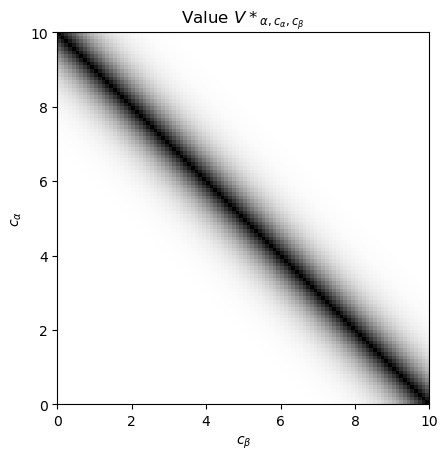

In [24]:
plt.matshow(V_map, cmap='grey', origin='lower', extent=[0, 10, 0, 10])
plt.gca().xaxis.set_ticks_position('bottom')
plt.xlabel(r'$c_{\beta}$')
plt.ylabel(r'$c_{\alpha}$')
plt.title(r'Value $V* _{\alpha, c_{\alpha}, c_{\beta}}$')

The black line across the plot represents the inconsistency in observations (e.g. if the cue at 'Beta' is 2 and the cue at 'Alpha' is 8). Given such inconsistency, choosing the right policy is a matter of guessing, so the value is the lowest (black). Given some consistency in cues (top right or bottom left cornets of the plot), the coices can be optimal which is reflected by the high Value

Arriving to 'Alpha' requires choosing 'C' at 'Beta', before even observing c_alpha, therefore it requires to figure out what c_alpha might be by observing c_beta

Next we create a function that will calculate $P(c_{\alpha} | c_{\beta})$ 

In [25]:
def Destribution(observation_alpha, observation_beta):
    """ Function to calculate the conditional probability of c_alpha given c_beta
    Args:
        observation_alpha: the observation of the alpha stage
        observation_beta: the observation of the beta stage
    Returns:
        conditional_prob: the conditional probability of c_alpha given c_beta
    """

    stage = 'alpha'
    state_1 = env.get_states(stage)[0]
    state_2 = env.get_states(stage)[1]
    mean_1 = env.means[stage][state_1]
    mean_2 = env.means[stage][state_2]
    l_1 = stats.norm(mean_1, sigma).pdf(observation_alpha)
    l_2 = stats.norm(mean_2, sigma).pdf(observation_alpha)

    stage = 'beta'
    state_1 = env.get_states(stage)[0]
    state_2 = env.get_states(stage)[1]
    mean_1 = env.means[stage][state_1]
    mean_2 = env.means[stage][state_2]
    l_3 = stats.norm(mean_1, sigma).pdf(observation_beta)
    l_4 = stats.norm(mean_2, sigma).pdf(observation_beta)

    # Calculate the joint probability of c_alpha and c_beta for the rightward motion
    joint_prob_right = np.outer(l_1, l_3)
    # Calculate the joint probability of c_alpha and c_beta for the leftward motion
    joint_prob_left = np.outer(l_2, l_4)
    # Calculate the total joint probability by averaging the joint probabilities of both means
    joint_prob = (joint_prob_left + joint_prob_right) / 2
    # joint_prob /= np.sum(joint_prob) # Normalize the joint probability
    # Calculate the marginal probability of c_beta
    marginal_c_beta = np.sum(joint_prob, axis=0)
    # Calculate the conditional probability of c_alpha given c_beta
    conditional_prob = np.divide(joint_prob, marginal_c_beta)

    return conditional_prob

In [26]:
c_alphas = np.linspace(0, 10, 100)
c_betas = np.linspace(0, 10, 100)
conditional_prob = Destribution(c_alphas, c_betas)

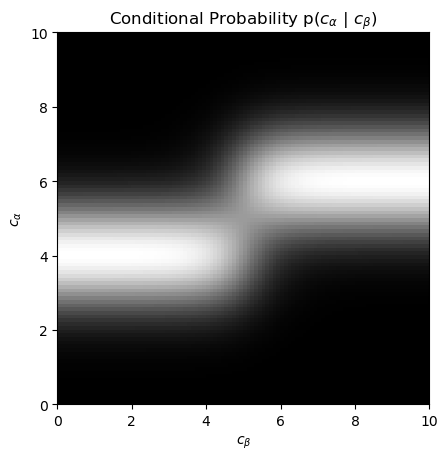

In [27]:
plt.matshow(conditional_prob, cmap='grey', extent=[
            0, 10, 0, 10], origin='lower', aspect='auto')
plt.gca().xaxis.set_ticks_position('bottom')
plt.gca().imshow(conditional_prob, cmap='grey', extent=[
    0, 10, 0, 10], origin='lower', aspect='auto')
plt.xlabel(r'$c_{\beta}$')
plt.ylabel(r'$c_{\alpha}$')
plt.title(r'Conditional Probability p($c_{\alpha}$ | $c_{\beta}$)')
plt.show()

We calculate the probability by summing up the joint probabilities of c_alpha and c_beta over possible values of c_beta in order to get marginal probability of c_alpha. After that we can calculate the conditional probability.
The graph shows that for the subject the probability of seeing the cue of the same 'sign' (i.e. leftward or rightward motion) at 'alpha' can be figured by the cue at 'beta'. In other words, the observation at 'alpha' must be more or less the same as the observation at 'beta' 

 We can now find the best action at $\beta$. We create a function that calculates the values associated with each of the actions

In [28]:
def best_action(action_beta, observation_beta):
    """ Function to calculate the best action to take in the beta stage
    Args:
        action_beta: the action in the beta stage
        observation_beta: the observation in the beta stage
    Returns:
        action_value: the action value
    """

    action_value = 0
    stage = 'beta'

    if action_beta == 'C':

        beta_obs = int(observation_beta*10)
        values_alpha = V_map[:, beta_obs]

        distr_x1 = np.array([stats.norm(env.means['alpha']['x1'], sigma).pdf(
            0.1*alpha_obs) for alpha_obs in range(100)])
        distr_x2 = np.array([stats.norm(env.means['alpha']['x2'], sigma).pdf(
            0.1*alpha_obs) for alpha_obs in range(100)])

        action_value = posterior(stage, observation_beta)[1] * np.sum(values_alpha @ distr_x1) * dc + posterior(
            stage, observation_beta)[0] * np.sum(values_alpha @ distr_x2) * dc + c_punishment

    elif action_beta == 'L':

        action_value = posterior(stage, observation_beta)

    elif action_beta == 'R':

        action_value = posterior(stage, observation_beta)

    return action_value

In [29]:
env = Environment()
c_punishment = -0.1
dc = 0.1
values = V_map

observations = np.arange(0, 10, 0.1)
C = [best_action('C', obs) for obs in observations]
RL = [np.max([best_action('L', obs), best_action('R', obs)])
      for obs in observations]

The graph shows that if the observation at 'beta' is ambiguos (i.e. values of c_beta are at 5, right in the middle of 4 and 6 - our distribution means), it is more optimal to choose 'Center' and get another cue, which is reflected by the Value 

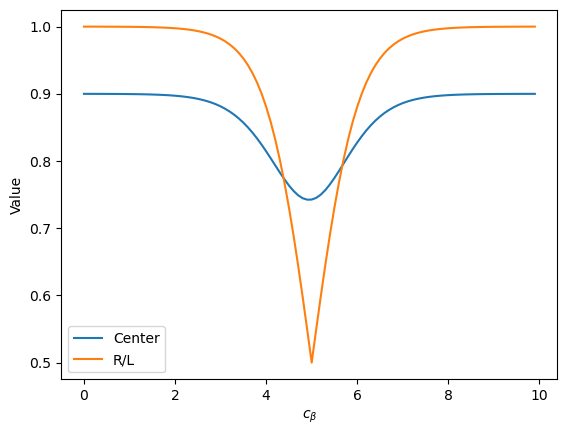

In [30]:
plt.plot(observations, C)
plt.plot(observations, RL)
plt.xlabel(r'$c_{\beta}$')
plt.ylabel('Value')
plt.legend(['Center', 'R/L'])
plt.show()

We can reduce (or increase) the range of observations at $\beta$ to the point where it is best to choose to wait for another observation (choosing C)

In [31]:
env = Environment()
c_punishment = -0.25
dc = 0.1
values = V_map

observations = np.arange(0, 10, 0.1)
C = [best_action('C', obs) for obs in observations]
RL = [np.max([best_action('L', obs), best_action('R', obs)])
      for obs in observations]

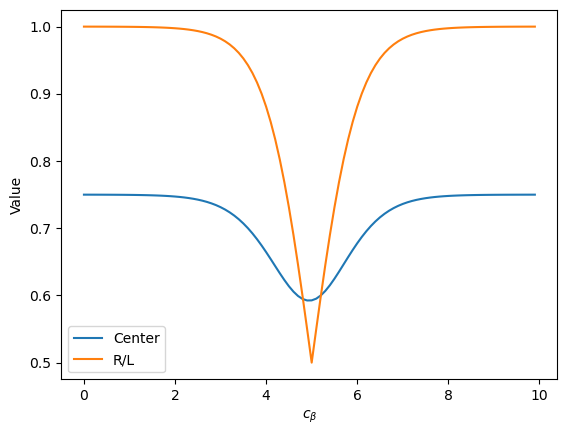

In [32]:
plt.plot(observations, C)
plt.plot(observations, RL)
plt.xlabel(r'$c_{\beta}$')
plt.ylabel('Value')
plt.legend(['Center', 'R/L'])
plt.show()

In [33]:
env = Environment()
c_punishment = -0.5
dc = 0.1
values = V_map

observations = np.arange(0, 10, 0.1)
C = [best_action('C', obs) for obs in observations]
RL = [np.max([best_action('L', obs), best_action('R', obs)])
      for obs in observations]

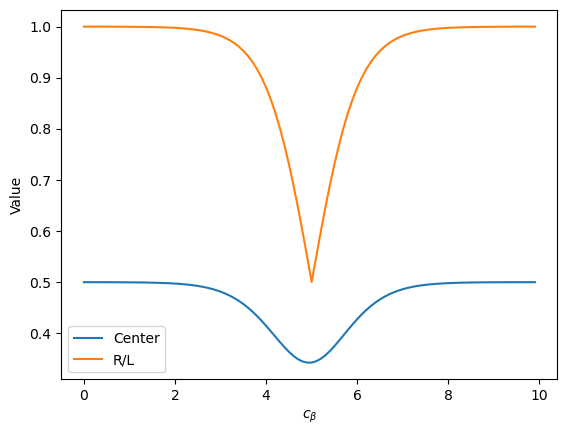

In [34]:
plt.plot(observations, C)
plt.plot(observations, RL)
plt.xlabel(r'$c_{\beta}$')
plt.ylabel('Value')
plt.legend(['Center', 'R/L'])
plt.show()

Increasing the punishment parameter basically decreases the Value of choosing 'Center' at 'Beta' all along the c_beta axis. At some point it becomes suboptimal to choose 'Center' even if the uncertainty about the observation at 'Beta' is the highest